In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import loadtxt
from itertools import product
from itertools import product
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [16]:
# load array
text_prob = loadtxt('data_files/text_prob.csv', delimiter=',')
img_prob = loadtxt('data_files/img_prob.csv', delimiter=',')
inter_prob = loadtxt('data_files/inter_prob.csv', delimiter=',')
# print the array

In [19]:
def ensemble_predictions(yhats,weights):
    # weighted sum across ensemble members
    #summed = tf.tensordot(yhats, weights, axes=((0),(0)))
    w, h = 1000, 4
    summed = [[0 for x in range(w)] for y in range(h)] 
    #print(summed)
    for i in range(1000):
        for x in range(4):
            summed[x][i]=0
            for y in range(2):
                summed[x][i]=summed[x][i]+(yhats[y][i][x])*weights[y]
    # argmax across classes
    result = np.argmax(summed, axis=0)
    return result
 
def evaluate_ensemble(yhats,testy,weights):
    # make prediction
    yhat = ensemble_predictions(yhats,weights)
    # calculate accuracy
    return accuracy_score(testy, yhat)

def loss_function(yhats,testy,weights):
    # normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return 1.0 - evaluate_ensemble(yhats,testy,weights)

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = tf.norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

testdata=pd.read_csv('data_files/test_labels.csv')

yhats=[text_prob,img_prob,inter_prob]
yhats = np.array(yhats,dtype='object')
#yhats = tf.convert_to_tensor(yhats,dtype=np.ndarray)
#print(yhats[1][0][0])

testy=[i for i in testdata['label']]
text_pred=pd.read_csv('data_files/text_pred.csv')
img_pred=pd.read_csv('data_files/img_pred.csv')
inter_pred=pd.read_csv('data_files/inter_pred.csv')
ytxt=[i for i in text_pred['text_pred']]
yimg=[i for i in img_pred['img_pred']]
yinter=[i for i in inter_pred['inter_pred']]
y=[ytxt,yimg,yinter]

n_members = 3
# evaluate each single model on the test set
for i in range(n_members):
    test_acc = accuracy_score(testy, y[i])
    print(test_acc)
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
weights=np.array(weights)

#weights = tf.convert_to_tensor(weights,dtype=np.float32)
score=evaluate_ensemble(yhats,testy,weights)
print('Weights Score: %.3f' % score)

0.368
0.901
0.867
Weights Score: 0.718


In [21]:
def grid_search(yhats,testy,weights):
    # define weights to consider
    w = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    best_score, best_weights = 0.0, None
    # iterate all possible combinations (cartesian product)
    for weights in product(w, repeat=3):
        # skip if all weights are equal
        if len(set(weights)) == 1:
            continue
        # hack, normalize weight vector
        weights = normalize(weights)
        # evaluate weights
        score = evaluate_ensemble(yhats, testy,weights)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.3f' % (best_weights, best_score))
    return list(best_weights)

In [22]:
# grid search weights
weights = grid_search(yhats, testy, weights)
score = evaluate_ensemble(yhats, testy,weights)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

>tf.Tensor([0.25 0.25 0.5 ], shape=(3,), dtype=float32) 0.718
>tf.Tensor([0.25 0.5  0.25], shape=(3,), dtype=float32) 0.875
>tf.Tensor([0.2 0.6 0.2], shape=(3,), dtype=float32) 0.886
>tf.Tensor([0.16666666 0.6666666  0.16666666], shape=(3,), dtype=float32) 0.892
>tf.Tensor([0.12499999 0.74999994 0.12499999], shape=(3,), dtype=float32) 0.893
>tf.Tensor([0.11111111 0.77777773 0.11111111], shape=(3,), dtype=float32) 0.894
>tf.Tensor([0.1 0.8 0.1], shape=(3,), dtype=float32) 0.895
>tf.Tensor([0.09090909 0.81818175 0.09090909], shape=(3,), dtype=float32) 0.897
Grid Search Weights: [<tf.Tensor: shape=(), dtype=float32, numpy=0.09090909>, <tf.Tensor: shape=(), dtype=float32, numpy=0.81818175>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09090909>], Score: 0.897


In [23]:
pred=ensemble_predictions(yhats,weights) 

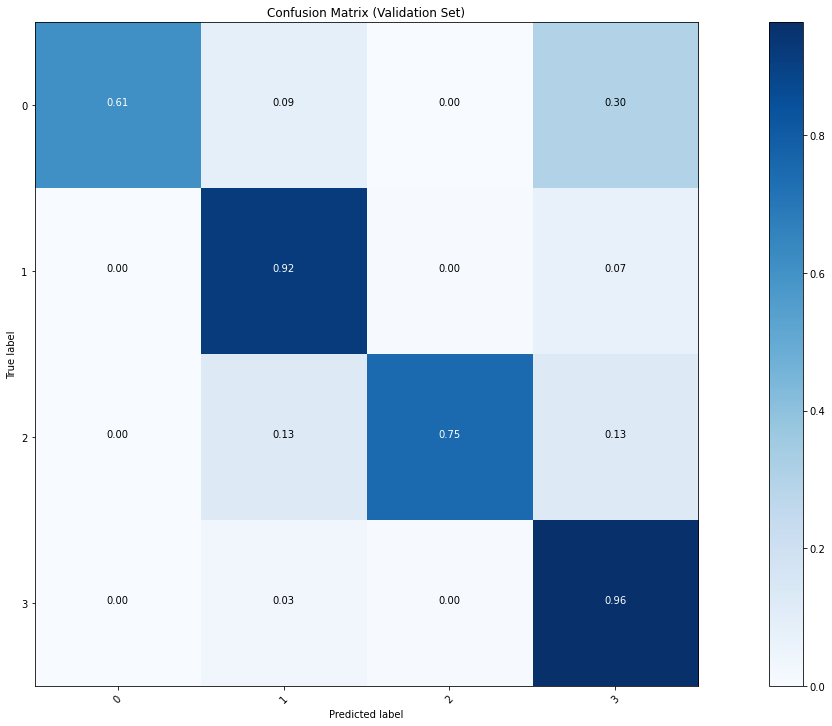

In [24]:
cnf_matrix = confusion_matrix(testy, pred)
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix,labels=None)

# precision = true_pos / (true_pos + false_p